In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import inspect
import os
from ipywidgets import interact, IntSlider, Dropdown, VBox, Output
from matplotlib.animation import FuncAnimation, HTMLWriter, FFMpegWriter
import datetime

In [2]:
d = 2


## Similar in structure to Dirk Data

x = np.array([[-1/2, 1], [-1/6,1], [1/6, 1], [1/2, 1]]) # Does not converge to 0 loss
y = np.array([1/4, 1/30, 1/30, 1/4])

x = np.array([[-1/2, 1], [-1/6,1], [1/6, 1], [1/2, 1]]) # Does not converge either despite negative values
y = np.array([1/4, -1/30, -1/30, 1/4])

# x = np.array([[-1/2, 1], [-1/6,1], [1/6, 1], [1/2, 1]]) # Does not converge either
# y = np.array([2, 1/2, 1/2, 2])

# x = np.array([[-1/2, 1], [-1/6,1], [1/6, 1], [1/2, 1]]) # DOES CONVERGE - Notice the behaviour of red weights, not visible when they increase in mangitude, 
# # could be w_1 going to 0 or w_2 to infinty, would this indicate a floating point error for why the above one does not converge?
# y = np.array([1, -1/2, -1/2, 1])

# x = np.array([[-2, 1], [-1,1], [1, 1], [2, 1]]) # This does converge, when the points are more spread out
# y = np.array([1/4, 1/30, 1/30, 1/4])

# x = np.array([[-2, 1], [-1,1], [1, 1], [2, 1]]) # s
# y = np.array([1/4, -1/30, -1/30, 1/4])

nu = 1/6
# From paper - double edged sword
x = np.array([[(-1 + nu), 1], [-nu,1], [(1-nu), 1]]) 
y = np.array([(1+nu), (nu), (1)])


## Three direction vectors?
# x = np.array([[-1 + nu, 1], [-nu,1], [1-nu, 1]]) 
# y = np.array([1+nu, -10*nu, 1])



# x = np.array([[-1.5, 1], [-1,1], [0.7, 1], [2, 1]]) 
# y = np.array([0.9, -0.3, 0.5, 0.2])

# x = np.array([[-1.5, 1], [-1,1], [0,1], [0.7, 1], [2, 1]]) # This recreates the example in the paper A.1
# y = np.array([0.9, -0.3, -0.3, 0.5, 0.2])

# x = np.array([[-1.5, 1], [0.7, 1], [2, 1]]) # No negative values # Why is there a kink at the end?
# y = np.array([0.9, 0.5, 0.2])

# # Achieves the U shape, BUT, it does not reach 0 loss (tested to 8 million steps)
# x = np.array([[-1.5, 1], [-1,1], [0,1], [0.7, 1], [1.2,1], [2, 1]]) # Extra negative value in an 'odd' spot
# y = np.array([0.9, -0.3, -0.3, 0.5, -0.4, 2.5])

# # Does not achieve the U shape
# x = np.array([[-1.5, 1], [-1,1], [0,1], [0.7, 1], [1.2,1], [2, 1]]) # Extra negative value in an 'odd' spot
# y = np.array([0.9, -0.3, -0.3, 0.5, -0.4, 0.2])

n = len(y)

In [3]:
def relu(x):
    return np.maximum(0, x)

def indicator(condition):
    return condition.astype(int)

In [4]:
# 2-Lyaer ReLu Neural Network
def twoLayerReluNet(a, w, x):
    return np.sum(a[:, np.newaxis] * relu(np.inner(w,x)), axis=0)

def loss(a, w, x, y):
    return (1/(2*n)) * np.sum((y - twoLayerReluNet(a, w, x))**2)

In [5]:
## Typical parameter gradients
def gradient_flow(a,w):
    
    relu_mask = (np.inner(w,x) > 0).astype(float)
    Dt = - 1/n * np.sum(((twoLayerReluNet(a, w, x) - y) * relu_mask)[:, :, np.newaxis] * x, axis=1) # Not sure about this one here

    grad_a = np.einsum('ij,ij->i', Dt, w) 
    grad_w = Dt * a[:, np.newaxis]
 
    return grad_a, grad_w

def generate_initial_data(lambda_param,m):
    mean = np.zeros(d)  # Mean vector with all zeros
    cov = np.eye(d)     # Covariance matrix as the identity matrix
    g = np.random.multivariate_normal(mean, cov, size=m)  # Generate n samples from the normal distribution
    w = lambda_param * g

    w_norms = np.linalg.norm(w, axis=1)
    s = np.random.choice([-1, 1], size=m)    
    a = w_norms * s

    return a, w, s

def generate_set_Splus_Sminus(s,w,m):
    # Compute dot products ⟨w_j^0, x_k⟩ for all j and k
    dot_products = np.inner(w,x)  # Shape (m, n)
    
    # Conditions
    pos_k_mask = y > 0  # Indices where y_k > 0
    neg_k_mask = y < 0  # Indices where y_k < 0

    Splus = np.array([i for i in range(m) if s[i] == 1 and np.all(dot_products[i, pos_k_mask] >= 0)])
    Sminus = np.array([i for i in range(m) if s[i] == -1 and np.all(dot_products[i, neg_k_mask] >= 0)])
    
    return Splus, Sminus

In [6]:
def gradient_descent(learning_rate, steps, lambda_param,m):

    a, w, s = generate_initial_data(lambda_param,m)
    sPlus, sMinus = generate_set_Splus_Sminus(s,w,m)

    np.save('weights\\s_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, steps), s)
    np.save('weights\\sPlus_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, steps), sPlus)
    np.save('weights\\sMinus_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, steps), sMinus)

    a_values = []
    w_values = []

    #for n in range(math.ceil(time/step_size)):
    for n in range(steps): 
        grad_a, grad_w = gradient_flow(a,w)
        a = a + learning_rate * grad_a
        w = w + learning_rate * grad_w

        # Save the current values of a, w, and b
        a_values.append(a.copy())
        w_values.append(w.copy())

    return a_values, w_values

In [7]:
def train(n_steps, learning_rate, lambda_param,m):
    a_values, w_values = gradient_descent(learning_rate, n_steps, lambda_param,m)

    # Convert lists to arrays for easier saving and plotting
    a_values = np.array(a_values)
    w_values = np.array(w_values)

    # Save the arrays to disk
    np.save('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps), a_values)
    np.save('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps), w_values)

    print(f'Completed training for steps: {n_steps}, learning rate: {learning_rate}, m value: {m}')

m = 60
lambda_param = 1e-6/ math.sqrt(m)
learning_rate = 1e-3
n_steps = 30000

train(n_steps, learning_rate, lambda_param,m)

Completed training for steps: 30000, learning rate: 0.001, m value: 60


In [12]:

current_a_values = np.load('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
current_w_values = np.load('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
current_s_values = np.load('weights\\s_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))

sPlus = np.load('weights\\sPlus_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
sMinus = np.load('weights\\sMinus_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
remaining = np.setdiff1d(np.arange(m), np.concatenate((sPlus, sMinus)))

# Generate the first coordinate ranging from -3 to 2
first_coord = np.linspace(-4, 4, 400)  # This will create an array from -3 to 2 (inclusive)

# Generate the second coordinate as an array of ones with the same length as first_coord
second_coord = np.ones_like(first_coord)

# Combine the two coordinates into a single array
x_graph = np.column_stack((first_coord, second_coord))
indices = np.arange(n_steps)

output = Output()

def get_loss(a_vals, w_vals, index):
    a = a_vals[index]
    w = w_vals[index]
    return loss(a, w, x, y)

def rescale_magnitudes(w):
    w_norms = 0.5 + (np.linalg.norm(w, axis=1))/(1 + np.linalg.norm(w, axis=1))
    return w_norms

def get_weight_plots(w):
    weights_x = - w[:,1] / w[:,0]
    w_norms = np.linalg.norm(w, axis=1)
    weights_y = current_s_values * w_norms
    return weights_x, weights_y

loss_values = np.zeros(n_steps)
for i in range(n_steps):
    loss_values[i] = get_loss(current_a_values, current_w_values, i)



def gen_plot(ax1, ax2, ax3, index, w, weight_plot_x, weight_plot_y, y_graph):
    r_lim = 0.8

    ax1.plot(np.arctan2(w[:,1], w[:,0])[sPlus], rescale_magnitudes(w)[sPlus], 'o', color='green', alpha=0.5)
    ax1.plot(np.arctan2(w[:,1], w[:,0])[sMinus], rescale_magnitudes(w)[sMinus], 'o', color='red', alpha=0.5)
    ax1.plot(np.arctan2(w[:,1], w[:,0])[remaining], rescale_magnitudes(w)[remaining], 'o', color='blue', alpha=0.5)
    ax1.plot(np.arctan2(x[:,1], x[:,0]), np.full(len(x),r_lim), 'x', color='black', alpha=0.5)
    ax1.grid(True)
    ax1.set_rlim(0.4,r_lim+0.01)
    ax1.set_yticklabels([])

    inner_circle = plt.Circle((0, 0), 0.1, transform=ax1.transProjectionAffine + ax1.transAxes, facecolor='white', edgecolor='black', zorder=10)
    ax1.add_patch(inner_circle)  # Overlay the circle


    ax2.scatter(x[:,0], y, c='green', alpha=0.5, label='Data points')
    ax2.plot(x_graph[:,0], y_graph, color='green', label=f'm={m}, index={index}', linewidth=1.5)
    ax2.scatter(weight_plot_x[sPlus], weight_plot_y[sPlus], c='green', marker=(5, 1))
    ax2.scatter(weight_plot_x[sMinus], weight_plot_y[sMinus], c='red', marker=(5, 1))
    ax2.scatter(weight_plot_x[remaining], weight_plot_y[remaining], c='blue', marker=(5, 1))
    ax2.grid(True)
    ax2.set_xlim(-40, 40)
    ax2.set_ylim(-3, 3)
    

    # Plot the precomputed loss values
    ax3.plot(indices, loss_values)
    ax3.axvline(x=index, color='blue', linestyle='--', linewidth=0.5)
    ax3.set_xlabel('Index')
    ax3.set_ylabel('Loss')
    ax3.grid(True)
    ax3.tick_params(bottom=True, left=False)
    
def plot_values(index):

    fig = plt.figure(figsize=(10, 8))
    ax1 = plt.subplot(2, 2, 1, polar=True)
    ax2 = plt.subplot(2, 2, 2)
    ax3 = plt.subplot(2, 1, 2)

    a = current_a_values[index]
    w = current_w_values[index]

    # Compute the corresponding y values
    y_graph = twoLayerReluNet(a, w, x_graph)

    weight_plot_x ,weight_plot_y = get_weight_plots(w)

    with output:
        output.clear_output(wait=True)
        gen_plot(ax1, ax2, ax3, index, w, weight_plot_x, weight_plot_y, y_graph)

        plt.show()

# Create a slider for selecting the index
slider = IntSlider(min=0, max=len(current_a_values)-1, step=1, value=0, description='Index')

# Use interact to create an interactive plot
interact(plot_values, index=slider)

# Display the output widget
display(output)

interactive(children=(IntSlider(value=0, description='Index', max=29999), Output()), _dom_classes=('widget-int…

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


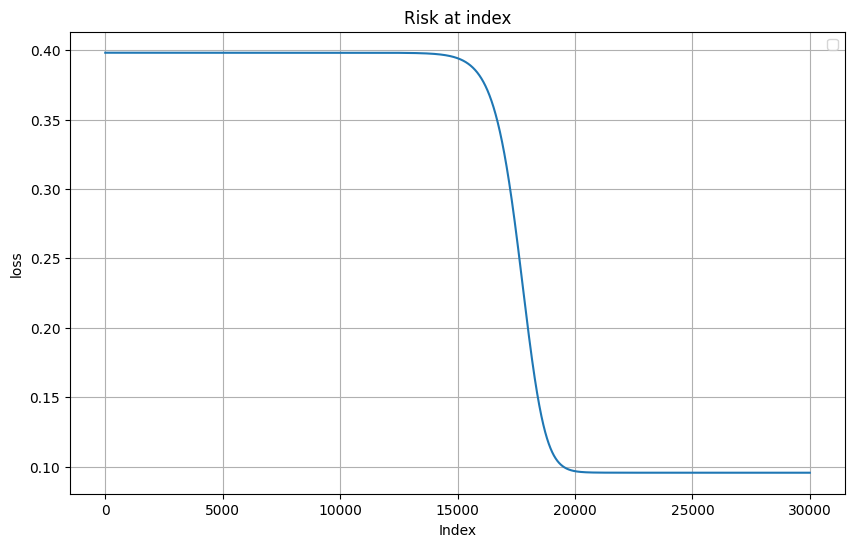

In [9]:
# Define the function to plot the values at a given index
def get_loss(a_vals, w_vals, index):
    a = a_vals[index]
    w = w_vals[index]
    
    return loss(a, w, x, y)

def generate_loss_plot(n_steps, learning_rate):

    # Create an array of indices
    indices = np.arange(n_steps)

    plt.figure(figsize=(10, 6))

    # Load the arrays from disk
    a_values = np.load('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    w_values = np.load('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))

    loss = np.zeros((int)(n_steps))
    # Load min and max values obtained by graph at index
    for n in range((int)(n_steps)):
        loss[n] = get_loss(a_values, w_values, n)

    # Plot the min and max values
    plt.plot(indices, loss)

        
    #filename = f'LossPlot_M{m}_Learning{learning_rate}_Steps{n_steps}.svg'

    plt.xlabel(f'Index')
    plt.ylabel('loss')
    plt.title('Risk at index') # TODO: Recheck the text for labels and title
    plt.legend()
    plt.grid(True)
    plt.show()

generate_loss_plot(n_steps, learning_rate)

In [10]:
def update(index):
    a = current_a_values[index]
    w = current_w_values[index]

    # Compute the corresponding y values
    y_graph = twoLayerReluNet(a, w, x_graph)
    weight_plot_x ,weight_plot_y = get_weight_plots(w)

    # Clear the previous plot and create a new one
    ax1.clear()
    ax2.clear()
    ax3.clear()

    gen_plot(ax1, ax2, ax3, index, w, weight_plot_x, weight_plot_y, y_graph)

# Set the total duration of the animation (in seconds)
total_duration = 30  # 10 seconds

# Skip to every 100th frame
frame_skip = 100
frames = range(0, n_steps, frame_skip)

# Calculate the interval between frames (in milliseconds)
interval = (total_duration * 1000) / len(frames)

# Create the animation
ani = FuncAnimation(fig, update, frames=frames, interval=interval, repeat=False)

# Create the writer
ffmpeg_writer = FFMpegWriter(fps=30)

# Generate a unique timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the animation
ani.save(f'animations\\animation_{timestamp}.mp4', writer=ffmpeg_writer)

# Display the animation
plt.show()